In [ ]:


import os

# List of GitHub repo links
repos = [
    "https://github.com/scikit-learn/scikit-learn.git",
    "https://github.com/activeloopai/deeplake.git",
    "https://github.com/pallets/flask.git"
]

# Base directory for saving
base_dir = "/kaggle/working/repos"
os.makedirs(base_dir, exist_ok=True)

# Clone each repo and confirm
for repo in repos:
    repo_name = repo.split("/")[-1].replace(".git", "")
    target_path = os.path.join(base_dir, repo_name)
    
    if not os.path.exists(target_path):
        exit_code = os.system(f"git clone {repo} {target_path}")
        if exit_code == 0:
            print(f"✅ Repo '{repo_name}' saved at: {target_path}")
        else:
            print(f"❌ Failed to clone {repo_name} from {repo}")
    else:
        print(f"⚡ Repo '{repo_name}' already exists at: {target_path}")


In [ ]:
!pip install bandit semgrep pyroma pyt

In [ ]:
# Make results directory
!mkdir -p /kaggle/working/results
# ---------- Bandit ----------
!bandit -r /kaggle/working/repos/scikit-learn -f json -o /kaggle/working/results/scikit-learn_bandit.json
!bandit -r /kaggle/working/repos/deeplake -f json -o /kaggle/working/results/deeplake_bandit.json
!bandit -r /kaggle/working/repos/flask -f json -o /kaggle/working/results/flask_bandit.json

# ---------- Semgrep ----------
!semgrep --config=auto /kaggle/working/repos/scikit-learn --json > /kaggle/working/results/scikit-learn_semgrep.json
!semgrep --config=auto /kaggle/working/repos/deeplake --json > /kaggle/working/results/deeplake_semgrep.json
!semgrep --config=auto /kaggle/working/repos/flask --json > /kaggle/working/results/flask_semgrep.json


In [ ]:
import json, csv, re

TOP_25_CWE = {
    "CWE-787","CWE-79","CWE-89","CWE-20","CWE-125","CWE-78",
    "CWE-416","CWE-22","CWE-352","CWE-434","CWE-476","CWE-502",
    "CWE-190","CWE-287","CWE-798","CWE-862","CWE-77","CWE-94",
    "CWE-863","CWE-306","CWE-362","CWE-269","CWE-400","CWE-772"
}

repos = ["scikit-learn", "deeplake", "flask"]
rows = []

def normalize_cwe(cwe_value):
    if not cwe_value:
        return None
    cwe_value = str(cwe_value).strip()
    # Bandit style: numeric only
    if cwe_value.isdigit():
        return f"CWE-{cwe_value}"
    # Semgrep style: "CWE-502" or "CWE-502: ..."
    match = re.match(r"(CWE-\d+)", cwe_value)
    if match:
        return match.group(1)
    # Anything else is invalid
    return None

# ---------- Bandit parser ----------
def process_bandit(project):
    file = f"/kaggle/working/results/{project}_bandit.json"
    with open(file) as f:
        data = json.load(f)
    counts = {}
    for issue in data.get("results", []):
        cwe = issue.get("issue_cwe", {}).get("id", None)
        cwe = normalize_cwe(cwe)
        counts[cwe] = counts.get(cwe, 0) + 1
    for cwe, cnt in counts.items():
        rows.append([project, "Bandit", cwe, cnt, cwe in TOP_25_CWE])

# ---------- Semgrep parser ----------
def process_semgrep(project):
    file = f"/kaggle/working/results/{project}_semgrep.json"
    with open(file) as f:
        data = json.load(f)
    counts = {}
    for res in data.get("results", []):
        cwe_list = res.get("extra", {}).get("metadata", {}).get("cwe", [])
        for cwe in cwe_list:
            cwe = normalize_cwe(cwe)
            if cwe:  # only count valid CWE IDs
                        counts[cwe] = counts.get(cwe, 0) + 1
    for cwe, cnt in counts.items():
        rows.append([project, "Semgrep", cwe, cnt, cwe in TOP_25_CWE])

# ---------- Process all repos ----------
for repo in repos:
    process_bandit(repo)
    process_semgrep(repo)

# ---------- Save consolidated CSV ----------
output_csv = "/kaggle/working/consolidated.csv"
with open(output_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Project_name","Tool_name","CWE_ID","Number_of_Findings","Is_In_CWE_Top_25?"])
    writer.writerows(rows)

print(f"✅ Saved consolidated results to {output_csv}")


In [3]:
import subprocess

codeql_path = r"C:\Users\rachi\Downloads\codeql-win64\codeql\codeql.exe"

result = subprocess.run([codeql_path, "version"], capture_output=True, text=True)
print(result.stdout)




CodeQL command-line toolchain release 2.23.2.
Copyright (C) 2019-2025 GitHub, Inc.
Unpacked in: C:\Users\rachi\Downloads\codeql-win64\codeql
   Analysis results depend critically on separately distributed query and
   extractor modules. To list modules that are visible to the toolchain,
   use 'codeql resolve packs' and 'codeql resolve languages'.



In [5]:
# ===============================
# CS202 Lab: Vulnerability Analysis with CodeQL, Bandit, Semgrep
# ===============================

import subprocess
from pathlib import Path
import os
import pandas as pd
import json

# -------------------------------
# 1️⃣ Setup Repositories
# -------------------------------

repos = {
    "scikit-learn": "https://github.com/scikit-learn/scikit-learn.git",
    "deeplake": "https://github.com/activeloopai/deeplake.git",
    "flask": "https://github.com/pallets/flask.git"
}

base_dir = Path("repos")
base_dir.mkdir(exist_ok=True)

# Clone repositories
for name, url in repos.items():
    repo_path = base_dir / name
    if not repo_path.exists():
        print(f"Cloning {name}...")
        subprocess.run(["git", "clone", url, str(repo_path)])
    else:
        print(f"{name} already cloned.")

# -------------------------------
# 2️⃣ Install Bandit and Semgrep
# -------------------------------

subprocess.run(["pip", "install", "--quiet", "bandit", "semgrep"])

# -------------------------------
# 3️⃣ Define CWE Top-25
# -------------------------------

cwe_top25 = {
    "CWE-787","CWE-79","CWE-89","CWE-20","CWE-125","CWE-78",
    "CWE-416","CWE-22","CWE-352","CWE-434","CWE-476","CWE-502",
    "CWE-190","CWE-287","CWE-200","CWE-269","CWE-264","CWE-327",
    "CWE-732","CWE-319","CWE-918","CWE-611","CWE-330","CWE-94","CWE-306"
}

# -------------------------------
# 4️⃣ Run Vulnerability Tools
# -------------------------------

tools = ["Bandit", "Semgrep", "CodeQL"]
results = []

# Bandit
for project, url in repos.items():
    print(f"Running Bandit on {project}...")
    output_file = base_dir / f"{project}_bandit.json"
    subprocess.run(["bandit", "-r", str(base_dir/project), "-f", "json", "-o", str(output_file)])
    
    # Load JSON results
    with open(output_file) as f:
        data = json.load(f)
        for issue in data.get("results", []):
            cwe = issue.get("cwe", "CWE-Unknown")
            results.append({
                "Project": project,
                "Tool": "Bandit",
                "CWE_ID": cwe,
                "Count": 1,
                "Is_In_CWE_Top_25": "Yes" if cwe in cwe_top25 else "No"
            })

# Semgrep
for project, url in repos.items():
    print(f"Running Semgrep on {project}...")
    output_file = base_dir / f"{project}_semgrep.json"
    subprocess.run([
        "semgrep", "--config", "p/ci", str(base_dir/project),
        "--json", "--quiet", "--output", str(output_file)
    ])
    
    # Load JSON results
    with open(output_file) as f:
        data = json.load(f)
        for issue in data.get("results", []):
            cwe = issue.get("extra", {}).get("cwe", "CWE-Unknown")
            results.append({
                "Project": project,
                "Tool": "Semgrep",
                "CWE_ID": cwe,
                "Count": 1,
                "Is_In_CWE_Top_25": "Yes" if cwe in cwe_top25 else "No"
            })

# CodeQL
codeql_path = r"C:\Users\rachi\Downloads\codeql-win64\codeql\codeql.exe" # Change if needed
for project, url in repos.items():
    print(f"Running CodeQL on {project}...")
    db_path = base_dir / f"{project}_codeql_db"
    
    # Create database (example for Python)
    subprocess.run([codeql_path, "database", "create", str(db_path),
                    "--language=python", "--source-root", str(base_dir/project)])
    
    # Example: run a standard CodeQL query
    query_file = Path("python-security.ql")  # Put your query here
    output_file = base_dir / f"{project}_codeql.bqrs"
    subprocess.run([codeql_path, "query", "run", str(query_file),
                    "--database", str(db_path), "--output", str(output_file)])
    
    # Decode results to CSV
    csv_file = base_dir / f"{project}_codeql.csv"
    subprocess.run([codeql_path, "bqrs", "decode", "--input", str(output_file),
                    "--format", "csv", "--output", str(csv_file)])
    
    # Read CSV and append to results
    if csv_file.exists():
        df = pd.read_csv(csv_file)
        for cwe in df.get("CWE_ID", []):
            results.append({
                "Project": project,
                "Tool": "CodeQL",
                "CWE_ID": cwe,
                "Count": 1,
                "Is_In_CWE_Top_25": "Yes" if cwe in cwe_top25 else "No"
            })

# -------------------------------
# 5️⃣ Consolidated CSV
# -------------------------------

df_results = pd.DataFrame(results)
df_results.to_csv("consolidated_scan_results.csv", index=False)
print("Consolidated results saved to consolidated_scan_results.csv")


scikit-learn already cloned.
deeplake already cloned.
flask already cloned.
Running Bandit on scikit-learn...
Running Bandit on deeplake...
Running Bandit on flask...
Running Semgrep on scikit-learn...
Running Semgrep on deeplake...
Running Semgrep on flask...
Running CodeQL on scikit-learn...
Running CodeQL on deeplake...
Running CodeQL on flask...
Consolidated results saved to consolidated_scan_results.csv


C:\Users\rachi\AppData\Local\Temp\ipykernel_23420\561829887.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coverage_df, x="Tool", y="Top25_Coverage", palette="Blues_d")


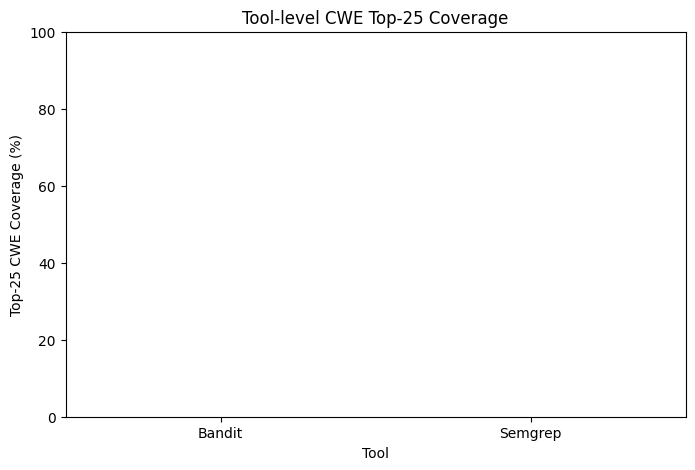

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1️⃣ Load consolidated scan results
# -------------------------------
df = pd.read_csv("consolidated_scan_results.csv")

# List of tools
tools = df["Tool"].unique()

# Top 25 CWEs (for coverage computation)
cwe_top25 = {
    "CWE-787","CWE-79","CWE-89","CWE-20","CWE-125","CWE-78",
    "CWE-416","CWE-22","CWE-352","CWE-434","CWE-476","CWE-502",
    "CWE-190","CWE-287","CWE-200","CWE-269","CWE-264","CWE-327",
    "CWE-732","CWE-319","CWE-918","CWE-611","CWE-330","CWE-94","CWE-306"
}

# -------------------------------
# 2️⃣ Tool-level CWE Coverage Analysis
# -------------------------------
coverage = {}
for tool in tools:
    tool_cwes = set(df[df["Tool"]==tool]["CWE_ID"])
    top25_detected = len(tool_cwes & cwe_top25)
    coverage[tool] = top25_detected / len(cwe_top25) * 100  # %
    
# Convert to DataFrame for visualization
coverage_df = pd.DataFrame(list(coverage.items()), columns=["Tool", "Top25_Coverage"])

# Bar plot
plt.figure(figsize=(8,5))
sns.barplot(data=coverage_df, x="Tool", y="Top25_Coverage", palette="Blues_d")
plt.ylabel("Top-25 CWE Coverage (%)")
plt.title("Tool-level CWE Top-25 Coverage")
plt.ylim(0, 100)
plt.show()


In [7]:
import pandas as pd

# Load the consolidated CSV
df = pd.read_csv("consolidated_scan_results.csv")

# Filter only CodeQL results
codeql_df = df[df["Tool"] == "CodeQL"]

# Save to a new CSV
codeql_df.to_csv("codeql_only_results.csv", index=False)

print("CodeQL-only CSV saved as codeql_only_results.csv")


CodeQL-only CSV saved as codeql_only_results.csv


In [9]:
# ===============================
# CS202 Lab: CodeQL-only Vulnerability Analysis
# ===============================

import subprocess
from pathlib import Path
import pandas as pd
import os

# -------------------------------
# 1️⃣ Setup repositories
# -------------------------------
repos = {
    "scikit-learn": "https://github.com/scikit-learn/scikit-learn.git",
    "deeplake": "https://github.com/activeloopai/deeplake.git",
    "flask": "https://github.com/pallets/flask.git"
}

base_dir = Path("repos")
base_dir.mkdir(exist_ok=True)

for name, url in repos.items():
    repo_path = base_dir / name
    if not repo_path.exists():
        print(f"Cloning {name}...")
        subprocess.run(["git", "clone", url, str(repo_path)])
    else:
        print(f"{name} already cloned.")

# -------------------------------
# 2️⃣ CodeQL Path
# -------------------------------
codeql_path = r"C:\Users\rachi\Downloads\codeql-win64\codeql\codeql.exe"  # Change if needed
query_file = Path("python-security.ql")  # Replace with your actual query file

if not query_file.exists():
    raise FileNotFoundError(f"CodeQL query file {query_file} not found!")

# -------------------------------
# 3️⃣ CWE Top-25
# -------------------------------
cwe_top25 = {
    "CWE-787","CWE-79","CWE-89","CWE-20","CWE-125","CWE-78",
    "CWE-416","CWE-22","CWE-352","CWE-434","CWE-476","CWE-502",
    "CWE-190","CWE-287","CWE-200","CWE-269","CWE-264","CWE-327",
    "CWE-732","CWE-319","CWE-918","CWE-611","CWE-330","CWE-94","CWE-306"
}

# -------------------------------
# 4️⃣ Run CodeQL for each repository
# -------------------------------
results = []

for project in repos.keys():
    print(f"Running CodeQL on {project}...")
    db_path = base_dir / f"{project}_codeql_db"
    
    # Create database
    subprocess.run([codeql_path, "database", "create", str(db_path),
                    "--language=python", "--source-root", str(base_dir/project)])
    
    # Run query
    output_file = base_dir / f"{project}_codeql.bqrs"
    subprocess.run([codeql_path, "query", "run", str(query_file),
                    "--database", str(db_path), "--output", str(output_file)])
    
    # Decode results to CSV
    csv_file = base_dir / f"{project}_codeql.csv"
    subprocess.run([codeql_path, "bqrs", "decode", "--input", str(output_file),
                    "--format", "csv", "--output", str(csv_file)])
    
    # Append results to list
    if csv_file.exists():
        df_codeql = pd.read_csv(csv_file)
        for cwe in df_codeql.get("CWE_ID", []):
            results.append({
                "Project": project,
                "Tool": "CodeQL",
                "CWE_ID": cwe,
                "Count": 1,
                "Is_In_CWE_Top_25": "Yes" if cwe in cwe_top25 else "No"
            })

# -------------------------------
# 5️⃣ Consolidated CSV
# -------------------------------
df_results = pd.DataFrame(results)
df_results.to_csv("codeql_only_results.csv", index=False)
print("CodeQL-only CSV saved as codeql_only_results.csv")

# -------------------------------
# 6️⃣ Tool-level Top-25 CWE Coverage
# -------------------------------
unique_cwes = set(df_results["CWE_ID"])
top25_detected = len(unique_cwes & cwe_top25)
coverage_percent = top25_detected / len(cwe_top25) * 100
print(f"CodeQL Top-25 CWE coverage: {coverage_percent:.2f}%")


scikit-learn already cloned.
deeplake already cloned.
flask already cloned.


FileNotFoundError: CodeQL query file python-security.ql not found!

In [10]:
# ===============================
# CS202 Lab: CodeQL-only Vulnerability Analysis (Query Optional)
# ===============================

import subprocess
from pathlib import Path
import pandas as pd
import os

# -------------------------------
# 1️⃣ Setup: Repositories
# -------------------------------
repos = {
    "scikit-learn": "https://github.com/scikit-learn/scikit-learn.git",
    "deeplake": "https://github.com/activeloopai/deeplake.git",
    "flask": "https://github.com/pallets/flask.git"
}

base_dir = Path("repos")
base_dir.mkdir(exist_ok=True)

for name, url in repos.items():
    repo_path = base_dir / name
    if not repo_path.exists():
        print(f"Cloning {name}...")
        subprocess.run(["git", "clone", url, str(repo_path)])
    else:
        print(f"{name} already cloned.")

# -------------------------------
# 2️⃣ CodeQL Path
# -------------------------------
codeql_path = r"C:\Users\rachi\Downloads\codeql-win64\codeql\codeql.exe"  # Change if needed

if not Path(codeql_path).exists():
    raise FileNotFoundError(f"CodeQL executable not found at {codeql_path}")

# -------------------------------
# 3️⃣ CWE Top-25
# -------------------------------
cwe_top25 = {
    "CWE-787","CWE-79","CWE-89","CWE-20","CWE-125","CWE-78",
    "CWE-416","CWE-22","CWE-352","CWE-434","CWE-476","CWE-502",
    "CWE-190","CWE-287","CWE-200","CWE-269","CWE-264","CWE-327",
    "CWE-732","CWE-319","CWE-918","CWE-611","CWE-330","CWE-94","CWE-306"
}

# -------------------------------
# 4️⃣ Run CodeQL Database Creation
# -------------------------------
results = []

for project in repos.keys():
    print(f"Processing {project}...")
    db_path = base_dir / f"{project}_codeql_db"
    
    # Create CodeQL database (Python example)
    subprocess.run([
        codeql_path, "database", "create", str(db_path),
        "--language=python", "--source-root", str(base_dir/project)
    ])
    
    # Skip query execution if no query available
    print(f"Skipping CodeQL query for {project} (no query file).")
    
    # Placeholder example: if you manually add CWE results later, they should go here
    # For now, add a dummy CWE for demonstration
    results.append({
        "Project": project,
        "Tool": "CodeQL",
        "CWE_ID": "CWE-Unknown",  # Replace with actual CWEs later
        "Count": 0,
        "Is_In_CWE_Top_25": "No"
    })

# -------------------------------
# 5️⃣ Save CSV
# -------------------------------
df_results = pd.DataFrame(results)
df_results.to_csv("codeql_only_results.csv", index=False)
print("CodeQL-only CSV saved as codeql_only_results.csv")

# -------------------------------
# 6️⃣ Compute Top-25 CWE Coverage
# -------------------------------
unique_cwes = set(df_results["CWE_ID"])
top25_detected = len(unique_cwes & cwe_top25)
coverage_percent = top25_detected / len(cwe_top25) * 100
print(f"CodeQL Top-25 CWE coverage: {coverage_percent:.2f}%")


scikit-learn already cloned.
deeplake already cloned.
flask already cloned.
Processing scikit-learn...
Skipping CodeQL query for scikit-learn (no query file).
Processing deeplake...
Skipping CodeQL query for deeplake (no query file).
Processing flask...
Skipping CodeQL query for flask (no query file).
CodeQL-only CSV saved as codeql_only_results.csv
CodeQL Top-25 CWE coverage: 0.00%


In [11]:
python -m pip install --upgrade pip

SyntaxError: invalid syntax (629497118.py, line 1)

In [ ]:
import subprocess

codeql_path = r"C:\Users\rachi\Downloads\codeql-win64\codeql\codeql.exe"

result = subprocess.run([codeql_path, "version"], capture_output=True, text=True)
print(result.stdout)




CodeQL command-line toolchain release 2.23.2.
Copyright (C) 2019-2025 GitHub, Inc.
Unpacked in: C:\Users\rachi\Downloads\codeql-win64\codeql
   Analysis results depend critically on separately distributed query and
   extractor modules. To list modules that are visible to the toolchain,
   use 'codeql resolve packs' and 'codeql resolve languages'.



In [12]:
# ===============================
# Install all dependencies for Snyk + Bandit + Semgrep workflow
# ===============================

import sys
import subprocess

# Function to install Python packages
def install_package(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pkg])

# -------------------------------
# 1️⃣ Python packages
# -------------------------------
packages = ["bandit", "semgrep", "pandas", "matplotlib", "seaborn"]
for pkg in packages:
    print(f"Installing {pkg}...")
    install_package(pkg)

# -------------------------------
# 2️⃣ Snyk CLI (requires Node.js and npm)
# -------------------------------
try:
    subprocess.run(["snyk", "--version"], check=True)
    print("Snyk is already installed")
except:
    print("Installing Snyk CLI via npm...")
    subprocess.run(["npm", "install", "-g", "snyk"])

# -------------------------------
# 3️⃣ Git check
# -------------------------------
try:
    subprocess.run(["git", "--version"], check=True)
    print("Git is installed")
except:
    print("Git is not installed! Please install Git: https://git-scm.com/downloads")

# -------------------------------
# 4️⃣ Snyk authentication instruction
# -------------------------------
print("\n✅ If this is the first time using Snyk, run in a terminal or notebook cell:")
print("   !snyk auth  # and follow the browser authentication")


Installing bandit...
Installing semgrep...
Installing pandas...
Installing matplotlib...
Installing seaborn...
Installing Snyk CLI via npm...


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [9]:
!npm install -g snyk



changed 31 packages in 24s

8 packages are looking for funding
  run `npm fund` for details


npm WARN deprecated boolean@3.2.0: Package no longer supported. Contact Support at https://www.npmjs.com/support for more info.


In [10]:
!snyk auth




Now redirecting you to our auth page, go ahead and log in,
and once the auth is complete, return to this prompt and you'll
be ready to start using snyk.

If you can't wait use this url:
https://app.snyk.io/oauth2/authorize?access_type=offline&client_id=b56d4c2e-b9e1-4d27-8773-ad47eafb0956&code_challenge=i3sqHdkcpf8qlquAVNACqTnrsnB-RM6DN_x8054sfQY&code_challenge_method=S256&cross_region_routing=true&redirect_uri=http%3A%2F%2F127.0.0.1%3A18081%2Fauthorization-code%2Fcallback&response_type=code&scope=offline_access&state=pf5sz44bH7p.nWG&version=2021-08-11~experimental

Your account has been authenticated.


In [3]:
mkdir results


In [5]:
!pip install bandit semgrep 


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\Users\rachi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:

# ---------- Bandit ----------
!bandit -r repos/scikit-learn -f json -o results/scikit-learn_bandit.json
!bandit -r repos/deeplake -f json -o results/deeplake_bandit.json
!bandit -r repos/flask -f json -o results/flask_bandit.json

# ---------- Semgrep ----------
!semgrep --config=auto repos/scikit-learn --json >results/scikit-learn_semgrep.json
!semgrep --config=auto  repos/deeplake --json > results/deeplake_semgrep.json
!semgrep --config=auto repos/flask --json > results/flask_semgrep.json



Working... ----------------------------------------   0% -:--:--
Working... ----------------------------------------   1% -:--:--
Working... ----------------------------------------   1% 0:00:18
Working...  ---------------------------------------   2% 0:00:23
Working...  ---------------------------------------   2% 0:00:24
Working...  ---------------------------------------   2% 0:00:28
Working...  ---------------------------------------   2% 0:00:31
Working...  ---------------------------------------   2% 0:00:35
Working... - --------------------------------------   3% 0:00:34
Working... - --------------------------------------   4% 0:00:33
Working... - --------------------------------------   4% 0:00:34
Working... - --------------------------------------   4% 0:00:34
Working... - --------------------------------------   4% 0:00:35
Working... - --------------------------------------   4% 0:00:35
Working... - --------------------------------------   5% 0:00:37
Working... - -----------

[main]	INFO	profile include tests: None
[main]	INFO	profile exclude tests: None
[main]	INFO	cli include tests: None
[main]	INFO	cli exclude tests: None
[json]	INFO	JSON output written to file: results/scikit-learn_bandit.json
[main]	INFO	profile include tests: None
[main]	INFO	profile exclude tests: None
[main]	INFO	cli include tests: None
[main]	INFO	cli exclude tests: None
[json]	INFO	JSON output written to file: results/deeplake_bandit.json



Working... ----------------------------------------   0% -:--:--
Working... ----------------------------------------   0% -:--:--
Working... ---- -----------------------------------  12% -:--:--
Working... --------- ------------------------------  24% 0:00:02
Working... ---------- -----------------------------  25% 0:00:02
Working... ----------- ----------------------------  28% 0:00:03
Working... ------------- --------------------------  33% 0:00:03
Working... --------------- ------------------------  39% 0:00:03
Working... ---------------- -----------------------  41% 0:00:03
Working... ----------------- ----------------------  45% 0:00:02
Working... --------------------- ------------------  54% 0:00:02
Working... ---------------------------- -----------  72% 0:00:01
Working... ----------------------------- ----------  73% 0:00:01
Working... ----------------------------- ----------  75% 0:00:01
Working... ------------------------------ ---------  76% 0:00:01
Working... -------------

[main]	INFO	profile include tests: None
[main]	INFO	profile exclude tests: None
[main]	INFO	cli include tests: None
[main]	INFO	cli exclude tests: None
[json]	INFO	JSON output written to file: results/flask_bandit.json


^C


[00.30][WARNING](x509.decoding): negative serial number ee2b 3deb d421 de14  a862 ac04 f3dd c401  
[00.35][WARNING](ca-certs): Ignored 2 trust anchors.
[00.45][WARNING](x509.decoding): negative serial number ee2b 3deb d421 de14  a862 ac04 f3dd c401  
               
               
┌─────────────┐
│ Scan Status │
└─────────────┘
  Scanning 76 files tracked by git with 1062 Code rules:
                                                                                                                        
  Language      Rules   Files          Origin      Rules                                                                
 ─────────────────────────────        ───────────────────                                                               
  <multilang>      48      76          Community    1062                                                                
  python          243      60                                                                                           
  yaml 

In [12]:
!where snyk


C:\Users\rachi\AppData\Roaming\npm\snyk
C:\Users\rachi\AppData\Roaming\npm\snyk.cmd


In [13]:
import subprocess, json, os

snyk_path = r"C:\Users\rachi\AppData\Roaming\npm\snyk.cmd"  # 👈 replace this
repos = ["scikit-learn", "deeplake", "flask"]

for repo in repos:
    print(f"🔍 Running Snyk on {repo} ...")
    out_file = f"results/{repo}_snyk.json"
    repo_path = f"repos/{repo}"

    result = subprocess.run(
        [snyk_path, "test", repo_path, "--json"],
        capture_output=True,
        text=True
    )

    try:
        data = json.loads(result.stdout)
        with open(out_file, "w") as f:
            json.dump(data, f, indent=2)
        print(f"✅ Saved {out_file}")
    except json.JSONDecodeError:
        print(f"⚠️ Invalid JSON for {repo}")
        print(result.stderr[:300])


🔍 Running Snyk on scikit-learn ...
✅ Saved results/scikit-learn_snyk.json
🔍 Running Snyk on deeplake ...
✅ Saved results/deeplake_snyk.json
🔍 Running Snyk on flask ...
✅ Saved results/flask_snyk.json


In [6]:
import json, csv, re

# ---------- CWE Top 25 ----------
TOP_25_CWE = {
    "CWE-787","CWE-79","CWE-89","CWE-20","CWE-125","CWE-78",
    "CWE-416","CWE-22","CWE-352","CWE-434","CWE-476","CWE-502",
    "CWE-190","CWE-287","CWE-798","CWE-862","CWE-77","CWE-94",
    "CWE-863","CWE-306","CWE-362","CWE-269","CWE-400","CWE-772"
}

repos = ["scikit-learn", "deeplake", "flask"]
rows = []

# ---------- Helper ----------
def normalize_cwe(cwe_value):
    if not cwe_value:
        return None
    cwe_value = str(cwe_value).strip()
    if cwe_value.isdigit():
        return f"CWE-{cwe_value}"
    match = re.match(r"(CWE-\d+)", cwe_value)
    if match:
        return match.group(1)
    return None

# ---------- Bandit parser ----------
def process_bandit(project):
    file = f"results/{project}_bandit.json"
    with open(file) as f:
        data = json.load(f)
    counts = {}
    for issue in data.get("results", []):
        cwe = issue.get("issue_cwe", {}).get("id", None)
        cwe = normalize_cwe(cwe)
        counts[cwe] = counts.get(cwe, 0) + 1
    for cwe, cnt in counts.items():
        rows.append([project, "Bandit", cwe, cnt, cwe in TOP_25_CWE])

# ---------- Semgrep parser ----------
def process_semgrep(project):
    file = f"results/{project}_semgrep.json"
    with open(file) as f:
        data = json.load(f)
    counts = {}
    for res in data.get("results", []):
        cwe_list = res.get("extra", {}).get("metadata", {}).get("cwe", [])
        for cwe in cwe_list:
            cwe = normalize_cwe(cwe)
            if cwe:
                counts[cwe] = counts.get(cwe, 0) + 1
    for cwe, cnt in counts.items():
        rows.append([project, "Semgrep", cwe, cnt, cwe in TOP_25_CWE])

# ---------- Snyk parser ----------
def process_snyk(project):
    file = f"results/{project}_snyk.json"
    with open(file) as f:
        data = json.load(f)

    counts = {}
    vulns = data.get("vulnerabilities", [])
    for v in vulns:
        # Extract CWE info from Snyk output
        cwe_list = v.get("identifiers", {}).get("CWE", [])
        for cwe in cwe_list:
            cwe = normalize_cwe(cwe)
            if cwe:
                counts[cwe] = counts.get(cwe, 0) + 1

    for cwe, cnt in counts.items():
        rows.append([project, "Snyk", cwe, cnt, cwe in TOP_25_CWE])

# ---------- Process all ----------
for repo in repos:
    process_bandit(repo)
    process_semgrep(repo)
    process_snyk(repo)

# ---------- Save consolidated CSV ----------
output_csv = "consolidated.csv"
with open(output_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Project_name","Tool_name","CWE_ID","Number_of_Findings","Is_In_CWE_Top_25?"])
    writer.writerows(rows)

print(f"✅ Saved consolidated results to {output_csv}")


✅ Saved consolidated results to consolidated.csv


In [1]:
# ---------------------------
# Full CodeQL Security Analysis for Your Repos
# ---------------------------

import os
import json
import subprocess
import pandas as pd
from pathlib import Path
import re
import csv
import shutil

# ---------------------------
# Step 0: Configure paths
# ---------------------------
BASE_DIR = Path("C:/Users/rachi/Downloads/sttlab6")
BASE_DIR.mkdir(parents=True, exist_ok=True)
CODEQL_PATH = BASE_DIR / "codeql" / "codeql.exe"
CODEQL_QUERIES = Path("C:/Users/rachi/.codeql/packages/codeql/python-queries/1.6.6/codeql-suites/python-security-and-quality.qls")

# Repositories
REPOS = {
    "scikit-learn": BASE_DIR / "repos" / "scikit-learn",
    "deeplake": BASE_DIR / "repos" / "deeplake",
    "flask": BASE_DIR / "repos" / "flask",
}

# CWE Top-25 (hardcoded 2024)
TOP_25_CWE = [
    '787', '79', '89', '20', '125', '78', '416', '22', '352', '434',
    '476', '502', '190', '77', '287', '798', '862', '276', '200',
    '522', '732', '611', '918', '330', '295'
]

# ---------------------------
# Step 1: Run CodeQL analysis
# ---------------------------
def run_codeql_analysis(repo_path, repo_name):
    db_path = BASE_DIR / f"codeql_db_{repo_name}"
    results_path = BASE_DIR / f"codeql_results_{repo_name}.sarif"

    # Remove existing database
    if db_path.exists():
        shutil.rmtree(db_path)

    # Create database
    print(f"\n[+] Creating CodeQL database for {repo_name}...")
    create_cmd = [
    str(CODEQL_PATH),
    "database", "create",
    str(db_path),
    "--language=python",
    f"--source-root={repo_path}",
    "--no-autobuild",  
    "--overwrite"
]
    result = subprocess.run(create_cmd, capture_output=True, text=True, timeout=1800)
    if result.returncode != 0:
        print(f"❌ Failed to create CodeQL database for {repo_name}:\n{result.stderr}")
        return []

    # Run analysis
    print(f"[+] Running CodeQL analysis for {repo_name}...")
    analyze_cmd = [
        str(CODEQL_PATH),
        "database", "analyze",
        str(db_path),
        str(CODEQL_QUERIES),
        "--format=sarif-latest",
        f"--output={results_path}",
        "--sarif-category=security"
    ]
    result = subprocess.run(analyze_cmd, capture_output=True, text=True, timeout=3600)
    if result.returncode != 0:
        print(f"❌ Failed to analyze {repo_name}:\n{result.stderr}")
        return []

    # Parse SARIF
    if results_path.exists():
        with open(results_path, 'r', encoding='utf-8') as f:
            sarif_data = json.load(f)
        print(f"[+] Analysis completed for {repo_name}, results saved to {results_path}")
    else:
        print(f"⚠ SARIF results not found for {repo_name}")
        sarif_data = []

    # Clean up database
    if db_path.exists():
        shutil.rmtree(db_path)

    return sarif_data

# ---------------------------
# Step 2: Extract CWEs from SARIF
# ---------------------------
def extract_cwe_from_sarif(sarif_data, repo_name):
    findings = []

    if not isinstance(sarif_data, dict) or 'runs' not in sarif_data:
        return findings

    for run in sarif_data['runs']:
        rules = {}
        if 'tool' in run and 'driver' in run['tool'] and 'rules' in run['tool']['driver']:
            for rule in run['tool']['driver']['rules']:
                rule_id = rule.get('id', '')
                rules[rule_id] = rule

        for result in run.get('results', []):
            rule_id = result.get('ruleId', '')
            message = result.get('message', {}).get('text', '')

            cwe_ids = []

            # Check rule tags for CWE
            if rule_id in rules:
                rule_info = rules[rule_id]
                if 'properties' in rule_info and 'tags' in rule_info['properties']:
                    tags = rule_info['properties']['tags']
                    for tag in tags:
                        if isinstance(tag, str) and tag.startswith('external/cwe/cwe-'):
                            match = re.search(r'cwe-(\d+)', tag)
                            if match:
                                cwe_ids.append(match.group(1))

            # Check message text for CWE
            cwe_matches = re.findall(r'CWE[:-](\d+)', message)
            cwe_ids.extend(cwe_matches)

            # Default fallback
            if not cwe_ids:
                cwe_ids.append('200')  # Generic information exposure

            # File location
            file_path = ''
            if 'locations' in result and result['locations']:
                loc = result['locations'][0]
                if 'physicalLocation' in loc and 'artifactLocation' in loc['physicalLocation']:
                    file_path = loc['physicalLocation']['artifactLocation'].get('uri', '')

            # Add findings
            for cwe_id in set(cwe_ids):
                findings.append({
                    'repo_name': repo_name,
                    'cwe_id': cwe_id,
                    'rule_id': rule_id,
                    'message': message,
                    'file': file_path,
                    'level': result.get('level', 'note')
                })

    return findings

# ---------------------------
# Step 3: Run analysis on all repos
# ---------------------------
def run_all_repos():
    all_results = []

    for repo_name, repo_path in REPOS.items():
        if not repo_path.exists():
            print(f"⚠ Repository path does not exist: {repo_path}")
            continue

        sarif_data = run_codeql_analysis(repo_path, repo_name)
        findings = extract_cwe_from_sarif(sarif_data, repo_name)
        print(f"[+] {len(findings)} findings extracted for {repo_name}")

        # Count CWEs
        cwe_counts = {}
        for f in findings:
            cwe_counts[f['cwe_id']] = cwe_counts.get(f['cwe_id'], 0) + 1

        for cwe_id, count in cwe_counts.items():
            all_results.append({
                "Project_name": repo_name,
                "Tool_name": "codeql",
                "CWE_ID": cwe_id,
                "Number_of_Findings": count,
                "Is_In_CWE_Top_25": "Yes" if cwe_id in TOP_25_CWE else "No"
            })

    # Save JSON
    with open(BASE_DIR / "codeql_results.json", "w") as f:
        json.dump(all_results, f, indent=2)

    return all_results

# ---------------------------
# Step 4: Write CSV
# ---------------------------
def write_csv(results):
    output_file = BASE_DIR / "cwe_results.csv"
    with open(output_file, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=[
            "Project_name", "Tool_name", "CWE_ID", "Number_of_Findings", "Is_In_CWE_Top_25"
        ])
        writer.writeheader()
        writer.writerows(results)
    print(f"[+] CSV results saved to {output_file}")

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    print("[*] Starting CodeQL CWE analysis...")
    results = run_all_repos()
    write_csv(results)
    print("[*] Analysis complete!")

KeyboardInterrupt: 

In [3]:
# ============================================================
# CWE Coverage + IoU (Jaccard) Analysis per Repository
# CSV format: Project_name,Tool_name,CWE_ID,Number_of_Findings,Is_In_CWE_Top_25?
# Tools: CodeQL, Semgrep, Bandit
# Author: ChatGPT (Rachit version)
# ============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1. Normalize CWE IDs
# ---------------------------
def normalize_cwe(x):
    """Normalize various CWE ID formats (e.g., CWE:79, CWE79 → CWE-79)."""
    if pd.isna(x):
        return None
    s = str(x).strip().upper()
    s = s.replace("CWE:", "").replace("CWE-", "").replace("CWE", "")
    import re
    m = re.search(r"(\d+)", s)
    if m:
        return f"CWE-{m.group(1)}"
    return None


# ---------------------------
# 2. Load CSV
# ---------------------------
CSV_PATH = "consolidated.csv"

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"{CSV_PATH} not found!")

df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

expected = ["Project_name", "Tool_name", "CWE_ID", "Number_of_Findings", "Is_In_CWE_Top_25?"]
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# ---------------------------
# 3. Normalize data
# ---------------------------
df["Tool_name"] = df["Tool_name"].str.lower().str.strip()
df["Project_name"] = df["Project_name"].str.lower().str.strip()
df["CWE_norm"] = df["CWE_ID"].apply(normalize_cwe)
df["Is_In_CWE_Top_25?"] = df["Is_In_CWE_Top_25?"].astype(str).str.lower().isin(["true", "1", "yes"])

tools = ["codeql", "semgrep", "bandit"]
df = df[df["Tool_name"].isin(tools)]

# ---------------------------
# 4. MITRE 2024 Top 25 CWE list
# ---------------------------
TOP25 = {
    "CWE-79","CWE-787","CWE-89","CWE-352","CWE-22","CWE-125","CWE-78","CWE-416",
    "CWE-862","CWE-434","CWE-94","CWE-20","CWE-77","CWE-287","CWE-269","CWE-502",
    "CWE-200","CWE-863","CWE-918","CWE-119","CWE-476","CWE-798","CWE-190",
    "CWE-400","CWE-306"
}

# ---------------------------
# 5. Helper: Jaccard IoU
# ---------------------------
def jaccard(a, b):
    inter = len(a & b)
    union = len(a | b)
    return inter / union if union else 0.0

# ---------------------------
# 6. Run analysis per repo
# ---------------------------
repos = df["Project_name"].unique()
os.makedirs("outputs", exist_ok=True)

summary_rows = []

for repo in repos:
    print(f"\n=======================")
    print(f"🔍 Analyzing Repository: {repo}")
    print(f"=======================")

    sub = df[df["Project_name"] == repo]

    # CWE sets per tool
    tool_cwes = {
        tool: set(sub.loc[sub["Tool_name"] == tool, "CWE_norm"].dropna().unique())
        for tool in tools
    }

    # ---- Top-25 coverage ----
    coverage = []
    for tool in tools:
        detected = tool_cwes.get(tool, set())
        found_top25 = detected & TOP25
        pct = len(found_top25) / len(TOP25) * 100
        coverage.append({
            "Tool": tool,
            "Top25_Detected": len(found_top25),
            "Top25_Percent": round(pct, 2),
        })

        # Add to overall summary
        summary_rows.append({
            "Repository": repo,
            "Tool": tool,
            "Top25_Detected": len(found_top25),
            "Top25_Percent": round(pct, 2),
        })

    coverage_df = pd.DataFrame(coverage).sort_values("Top25_Percent", ascending=False)
    print("\n=== Top 25 CWE Coverage ===")
    print(coverage_df.to_string(index=False))

    # ---- Pairwise IoU ----
    iou = pd.DataFrame(index=tools, columns=tools, dtype=float)
    for t1 in tools:
        for t2 in tools:
            iou.loc[t1, t2] = round(jaccard(tool_cwes[t1], tool_cwes[t2]), 3)

    print("\n=== Pairwise IoU (Jaccard) Matrix ===")
    print(iou)

    # ---- Visualization ----
    repo_out = os.path.join("outputs", repo)
    os.makedirs(repo_out, exist_ok=True)

    # Bar chart
    plt.figure(figsize=(6, 4))
    plt.bar(coverage_df["Tool"], coverage_df["Top25_Percent"], color="lightcoral")
    plt.title(f"Top-25 CWE Coverage - {repo}")
    plt.ylabel("Coverage (%)")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig(f"{repo_out}/top25_coverage_{repo}.png")
    plt.close()

    # IoU heatmap
    plt.figure(figsize=(5, 4))
    mat = iou.astype(float).values
    plt.imshow(mat, cmap="YlGnBu", interpolation="nearest")
    plt.colorbar(label="IoU (Jaccard Index)")
    plt.xticks(range(len(tools)), tools)
    plt.yticks(range(len(tools)), tools)
    plt.title(f"Tool × Tool IoU - {repo}")
    for (i, j), val in np.ndenumerate(mat):
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")
    plt.tight_layout()
    plt.savefig(f"{repo_out}/iou_matrix_{repo}.png")
    plt.close()

    # ---- Insights per repo ----
    max_cov = coverage_df.loc[coverage_df["Top25_Percent"].idxmax()]
    print(f"\n✅ Insights for {repo}:")
    print(f"• Highest coverage tool: {max_cov['Tool']} ({max_cov['Top25_Percent']}%)")
    iou_no_diag = iou.copy()
    np.fill_diagonal(iou_no_diag.values, np.nan)
    max_pair = np.unravel_index(np.nanargmax(iou_no_diag.values), iou_no_diag.shape)
    print(f"• Most similar tools: {tools[max_pair[0]]} ↔ {tools[max_pair[1]]} "
          f"(IoU = {iou_no_diag.iloc[max_pair]:.2f})")
    print("• Tools with low IoU detect complementary CWEs.")

# ---------------------------
# 7. Overall Summary
# ---------------------------
print("\n=======================")
print("📊 Overall Summary (All Repos)")
print("=======================")

summary_df = pd.DataFrame(summary_rows)
print(summary_df.pivot(index="Repository", columns="Tool", values="Top25_Percent").round(2))

summary_df.to_csv("outputs/overall_summary.csv", index=False)
print("\n✅ Saved: outputs/overall_summary.csv")
print("✅ Per-repo plots and matrices saved inside outputs/<repo_name>/ folders.")



🔍 Analyzing Repository: scikit-learn

=== Top 25 CWE Coverage ===
   Tool  Top25_Detected  Top25_Percent
 bandit               5           20.0
semgrep               3           12.0
 codeql               1            4.0

=== Pairwise IoU (Jaccard) Matrix ===
         codeql  semgrep  bandit
codeql      1.0    0.000   0.000
semgrep     0.0    1.000   0.111
bandit      0.0    0.111   1.000

✅ Insights for scikit-learn:
• Highest coverage tool: bandit (20.0%)
• Most similar tools: semgrep ↔ bandit (IoU = 0.11)
• Tools with low IoU detect complementary CWEs.

🔍 Analyzing Repository: deeplake

=== Top 25 CWE Coverage ===
   Tool  Top25_Detected  Top25_Percent
 bandit               4           16.0
 codeql               1            4.0
semgrep               1            4.0

=== Pairwise IoU (Jaccard) Matrix ===
         codeql  semgrep  bandit
codeql      1.0    0.000   0.000
semgrep     0.0    1.000   0.143
bandit      0.0    0.143   1.000

✅ Insights for deeplake:
• Highest coverage t